In [654]:
!pip install -q catboost xgboost shap plotly

In [655]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import *
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

import xgboost as xgb
import catboost as cb
import shap
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [656]:
df = pd.read_csv('/content/Airline_Delay_Cause.csv')

In [657]:
df.head()

,year,month,carrier,carrier_name,airport,airport_name,arr_flights,arr_del15,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,arr_delay,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay
0,2023,12,9E,Endeavor Air Inc.,ABE,"Allentown/Bethlehem/Easton, PA: Lehigh Valley ...",72.0,5.0,2.46,1.00,0.73,0.0,0.81,0.0,0.0,672.0,61.0,574.0,20.0,0.0,17.0
1,2023,12,9E,Endeavor Air Inc.,AEX,"Alexandria, LA: Alexandria International",62.0,7.0,4.25,0.00,1.00,0.0,1.75,0.0,0.0,348.0,252.0,0.0,33.0,0.0,63.0
2,2023,12,9E,Endeavor Air Inc.,AGS,"Augusta, GA: Augusta Regional at Bush Field",95.0,10.0,5.94,0.00,1.06,0.0,3.00,0.0,0.0,859.0,536.0,0.0,47.0,0.0,276.0
3,2023,12,9E,Endeavor Air Inc.,ALB,"Albany, NY: Albany International",23.0,2.0,0.56,0.00,0.00,0.0,1.44,1.0,0.0,75.0,9.0,0.0,0.0,0.0,66.0
4,2023,12,9E,Endeavor Air Inc.,ATL,"Atlanta, GA: Hartsfield-Jackson Atlanta Intern...",2111.0,256.0,76.88,8.75,52.43,0.0,117.94,1.0,0.0,21424.0,8906.0,732.0,1487.0,0.0,10299.0


In [658]:
df.shape

(179338, 21)

In [659]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 179338 entries, 0 to 179337
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   year                 179338 non-null  int64  
 1   month                179338 non-null  int64  
 2   carrier              179338 non-null  object 
 3   carrier_name         179338 non-null  object 
 4   airport              179338 non-null  object 
 5   airport_name         179338 non-null  object 
 6   arr_flights          178997 non-null  float64
 7   arr_del15            178747 non-null  float64
 8   carrier_ct           178997 non-null  float64
 9   weather_ct           178997 non-null  float64
 10  nas_ct               178997 non-null  float64
 11  security_ct          178997 non-null  float64
 12  late_aircraft_ct     178997 non-null  float64
 13  arr_cancelled        178997 non-null  float64
 14  arr_diverted         178997 non-null  float64
 15  arr_delay        

In [660]:
print(df.isnull().sum())

year                     0
month                    0
carrier                  0
carrier_name             0
airport                  0
airport_name             0
arr_flights            341
arr_del15              591
carrier_ct             341
weather_ct             341
nas_ct                 341
security_ct            341
late_aircraft_ct       341
arr_cancelled          341
arr_diverted           341
arr_delay              341
carrier_delay          341
weather_delay          341
nas_delay              341
security_delay         341
late_aircraft_delay    341
dtype: int64


In [661]:
numerical_cols = ['arr_flights', 'arr_del15', 'carrier_ct', 'weather_ct', 'nas_ct',
                 'security_ct', 'late_aircraft_ct', 'arr_cancelled', 'arr_diverted',
                 'arr_delay', 'carrier_delay', 'weather_delay', 'nas_delay',
                 'security_delay', 'late_aircraft_delay']

for col in numerical_cols:
    if col in df.columns:
        df[col] = df[col].fillna(df[col].median())

In [662]:
df['delay_rate'] = df['arr_del15'] / (df['arr_flights'])
df['is_delayed'] = (df['delay_rate'] > 0.20).astype(int)

print(f"Delayed flights distribution: {df['is_delayed'].value_counts()}")

Delayed flights distribution: is_delayed
0    113712
1     65626
Name: count, dtype: int64


In [612]:
controllable_cts = ['carrier_ct', 'late_aircraft_ct']
uncontrollable_cts = ['weather_ct', 'nas_ct', 'security_ct']

controllable_delays = ['carrier_delay', 'late_aircraft_delay', 'arr_cancelled', 'arr_diverted']
uncontrollable_delays = ['weather_delay', 'nas_delay', 'security_delay']

In [663]:
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'

df['season'] = df['month'].apply(get_season)

df['total_controllable_delay'] = df['carrier_delay'] + df['late_aircraft_delay']
df['total_uncontrollable_delay'] = df['weather_delay'] + df['nas_delay'] + df['security_delay']

df['delay_per_flight'] = df['arr_delay'] / df['arr_flights']
df['carrier_delay_rate'] = df['carrier_delay'] / (df['arr_delay'] + 1)
df['late_aircraft_delay_rate'] = df['late_aircraft_delay'] / (df['arr_delay'] + 1)

df['carrier_ct_rate'] = df['carrier_ct'] / df['arr_flights']
df['weather_ct_rate'] = df['weather_ct'] / df['arr_flights']
df['nas_ct_rate'] = df['nas_ct'] / df['arr_flights']
df['late_aircraft_ct_rate'] = df['late_aircraft_ct'] / df['arr_flights']

In [664]:
controllable_weight = 0.8
uncontrollable_weight = 0.2

controllable_impact = (
    df['carrier_delay'] * 0.4 +
    df['late_aircraft_delay'] * 0.4 +
    df['arr_cancelled'] * 0.1 +
    df['arr_diverted'] * 0.1
) * controllable_weight

uncontrollable_impact = (
    df['weather_delay'] * 0.5 +
    df['nas_delay'] * 0.3 +
    df['security_delay'] * 0.2
) * uncontrollable_weight

df['oai_score'] = controllable_impact / (controllable_impact + uncontrollable_impact + 1)

print(f"OAI Score calculated for {len(df)} flights")
print(f"Mean OAI Score: {df['oai_score'].mean():.4f}")
print(f"Median OAI Score: {df['oai_score'].median():.4f}")
print(f"High Controllability (OAI > 0.7): {(df['oai_score'] > 0.7).sum():,} flights ({(df['oai_score'] > 0.7).mean()*100:.1f}%)")
print(f"Low Controllability (OAI < 0.3): {(df['oai_score'] < 0.3).sum():,} flights ({(df['oai_score'] < 0.3).mean()*100:.1f}%)")

OAI Score calculated for 179338 flights
Mean OAI Score: 0.8499
Median OAI Score: 0.9340
High Controllability (OAI > 0.7): 159,627 flights (89.0%)
Low Controllability (OAI < 0.3): 11,669 flights (6.5%)


In [665]:
print("\nValue Counts for 'is_delayed':")
print(df['is_delayed'].value_counts(normalize=True))

print("\nTop 5 Airlines by Total Flights:")
print(df.groupby('carrier_name')['arr_flights'].sum().nlargest(5))

print("\nTop 5 Airports by Total Flights:")
print(df.groupby('airport_name')['arr_flights'].sum().nlargest(5))

print("\nTop 5 Airports by Average Delay Rate (among those with flights):")

airport_delay_rate = df[df['arr_flights'] > 0].groupby('airport_name')['delay_rate'].mean().nlargest(5)
print(airport_delay_rate)

print("\nTop 5 Airports by Average Total Delay Minutes:")
airport_avg_delay = df.groupby('airport_name')['arr_delay'].mean().nlargest(5)
print(airport_avg_delay)

print("\nDelay Contribution by Cause (Total Minutes):")
delay_causes_total = df[[
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'
]].sum()
print(delay_causes_total.sort_values(ascending=False))

print("\nMean Delay Minutes per Flight by Cause:")
delay_causes_mean = df[[
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay'
]].mean()
print(delay_causes_mean.sort_values(ascending=False))


Value Counts for 'is_delayed':
is_delayed
0    0.634065
1    0.365935
Name: proportion, dtype: float64

Top 5 Airlines by Total Flights:
carrier_name
Southwest Airlines           7488028.0
SkyWest Airlines Inc.        6275611.0
Delta Air Lines Network      5151284.0
American Airlines Network    4984564.0
Southwest Airlines Co.       3890743.0
Name: arr_flights, dtype: float64

Top 5 Airports by Total Flights:
airport_name
Atlanta, GA: Hartsfield-Jackson Atlanta International     3138514.0
Chicago, IL: Chicago O'Hare International                 2717844.0
Dallas/Fort Worth, TX: Dallas/Fort Worth International    2296203.0
Denver, CO: Denver International                          2268081.0
Los Angeles, CA: Los Angeles International                1834321.0
Name: arr_flights, dtype: float64

Top 5 Airports by Average Delay Rate (among those with flights):
airport_name
Youngstown/Warren, OH: Youngstown-Warren Regional    1.000000
Mobile, AL: Mobile Downtown                          0.613

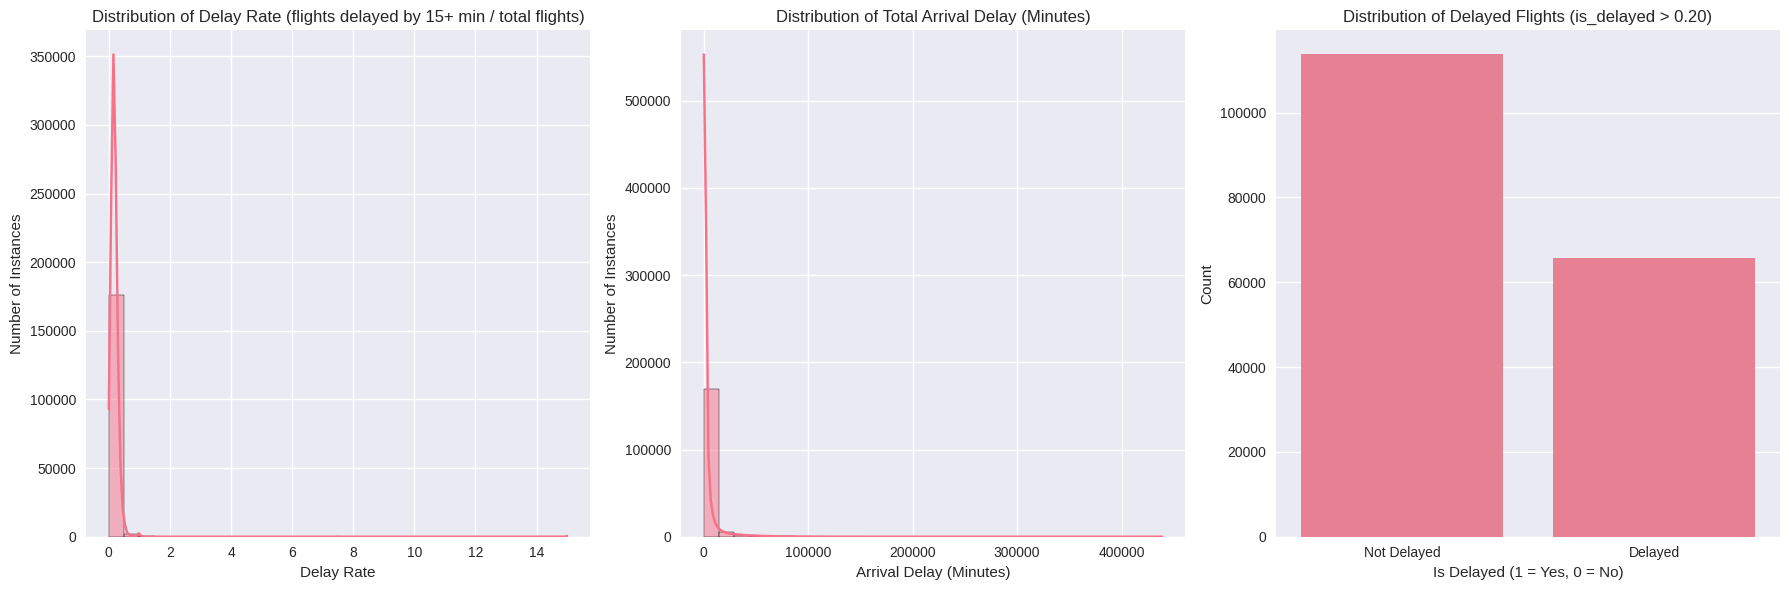

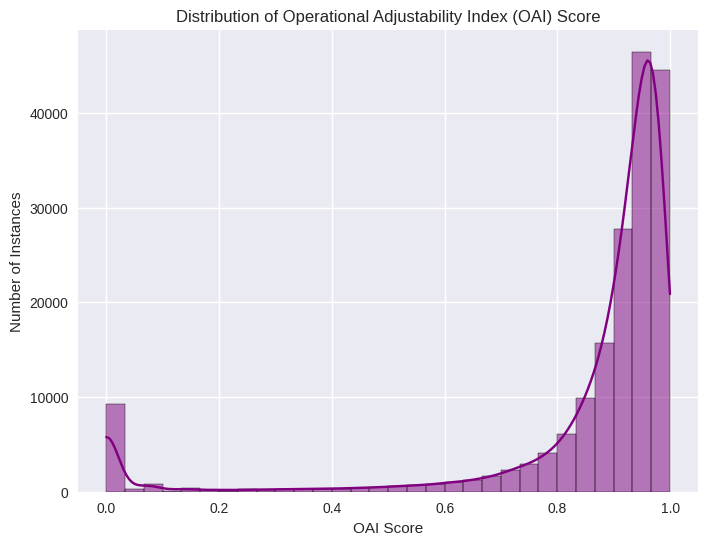

In [617]:
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
sns.histplot(df['delay_rate'], bins=30, kde=True)
plt.title('Distribution of Delay Rate (flights delayed by 15+ min / total flights)')
plt.xlabel('Delay Rate')
plt.ylabel('Number of Instances')

plt.subplot(1, 3, 2)
sns.histplot(df['arr_delay'], bins=30, kde=True)
plt.title('Distribution of Total Arrival Delay (Minutes)')
plt.xlabel('Arrival Delay (Minutes)')
plt.ylabel('Number of Instances')

plt.subplot(1, 3, 3)
sns.countplot(x='is_delayed', data=df)
plt.title('Distribution of Delayed Flights (is_delayed > 0.20)')
plt.xlabel('Is Delayed (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Not Delayed', 'Delayed'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 6))
sns.histplot(df['oai_score'], bins=30, kde=True, color='purple')
plt.title('Distribution of Operational Adjustability Index (OAI) Score')
plt.xlabel('OAI Score')
plt.ylabel('Number of Instances')
plt.show()

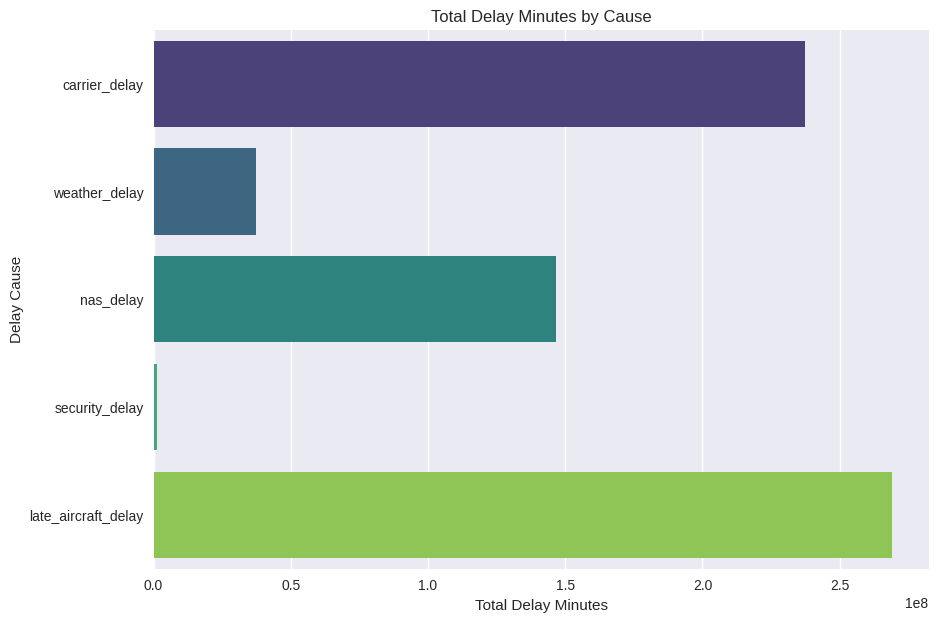

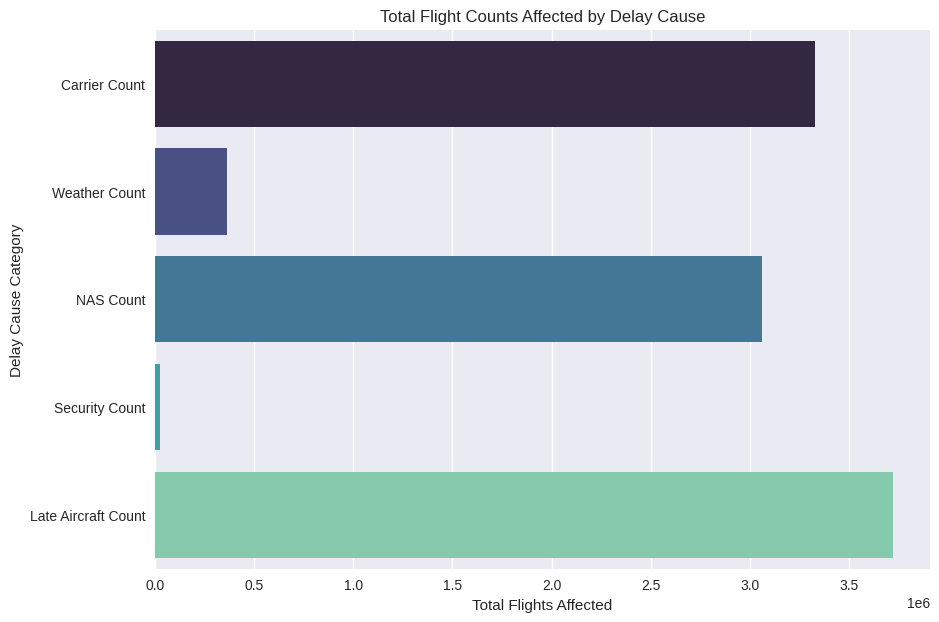

In [666]:
delay_causes_sum = df[['carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay']].sum()

plt.figure(figsize=(10, 7))
sns.barplot(x=delay_causes_sum.values, y=delay_causes_sum.index, palette='viridis')
plt.title('Total Delay Minutes by Cause')
plt.xlabel('Total Delay Minutes')
plt.ylabel('Delay Cause')
plt.show()

delay_counts_sum = df[['carrier_ct', 'weather_ct', 'nas_ct', 'security_ct', 'late_aircraft_ct']].sum()
delay_counts_sum.index = ['Carrier Count', 'Weather Count', 'NAS Count', 'Security Count', 'Late Aircraft Count']

plt.figure(figsize=(10, 7))
sns.barplot(x=delay_counts_sum.values, y=delay_counts_sum.index, palette='mako')
plt.title('Total Flight Counts Affected by Delay Cause')
plt.xlabel('Total Flights Affected')
plt.ylabel('Delay Cause Category')
plt.show()

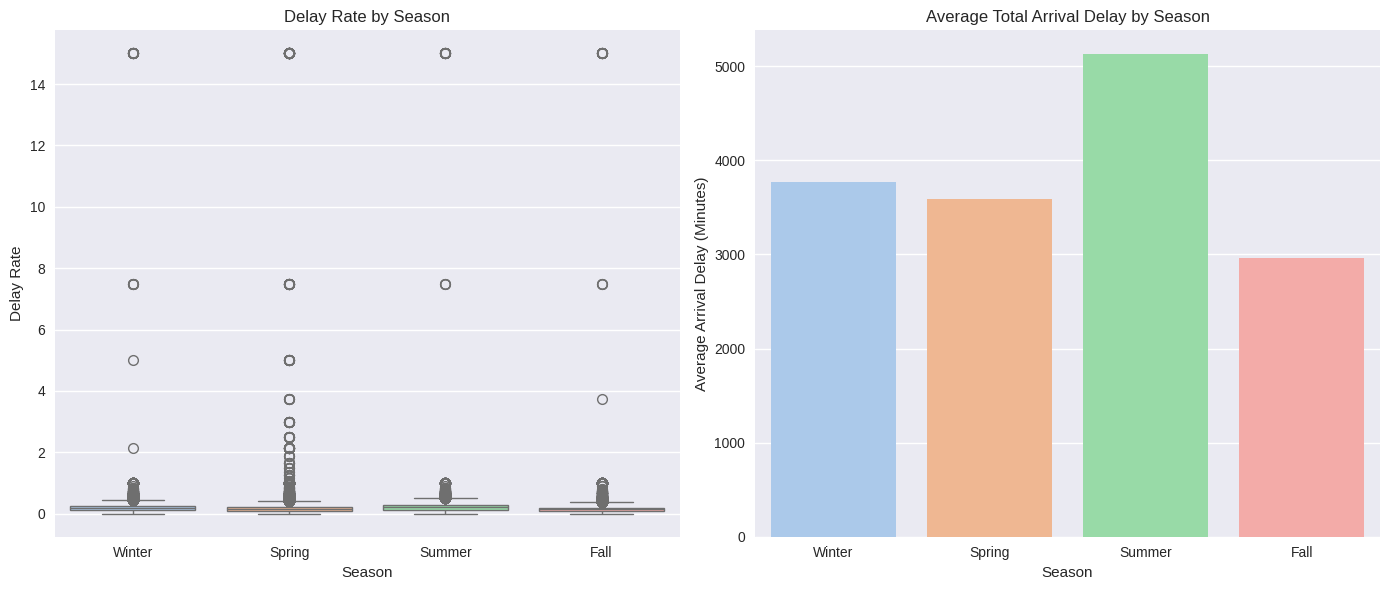

<Figure size 1600x800 with 0 Axes>

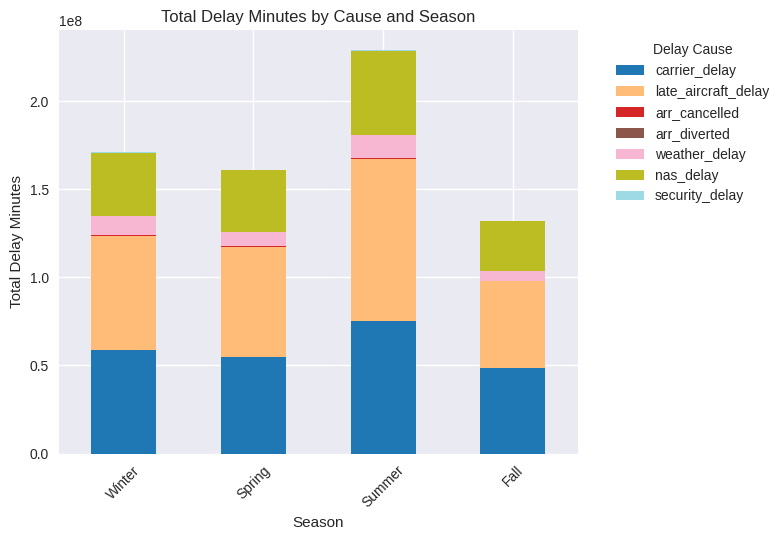

In [667]:
season_order = ['Winter', 'Spring', 'Summer', 'Fall']
df['season'] = pd.Categorical(df['season'], categories=season_order, ordered=True)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.boxplot(x='season', y='delay_rate', data=df, palette='pastel')
plt.title('Delay Rate by Season')
plt.xlabel('Season')
plt.ylabel('Delay Rate')

plt.subplot(1, 2, 2)
sns.barplot(x='season', y='arr_delay', data=df.groupby('season')['arr_delay'].mean().reset_index(), palette='pastel')
plt.title('Average Total Arrival Delay by Season')
plt.xlabel('Season')
plt.ylabel('Average Arrival Delay (Minutes)')

plt.tight_layout()
plt.show()

# Delay causes by season
delay_by_season_causes = df.groupby('season')[controllable_delays + uncontrollable_delays].sum()

plt.figure(figsize=(16, 8))
delay_by_season_causes.plot(kind='bar', stacked=True, cmap='tab20')
plt.title('Total Delay Minutes by Cause and Season')
plt.xlabel('Season')
plt.ylabel('Total Delay Minutes')
plt.xticks(rotation=45)
plt.legend(title='Delay Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

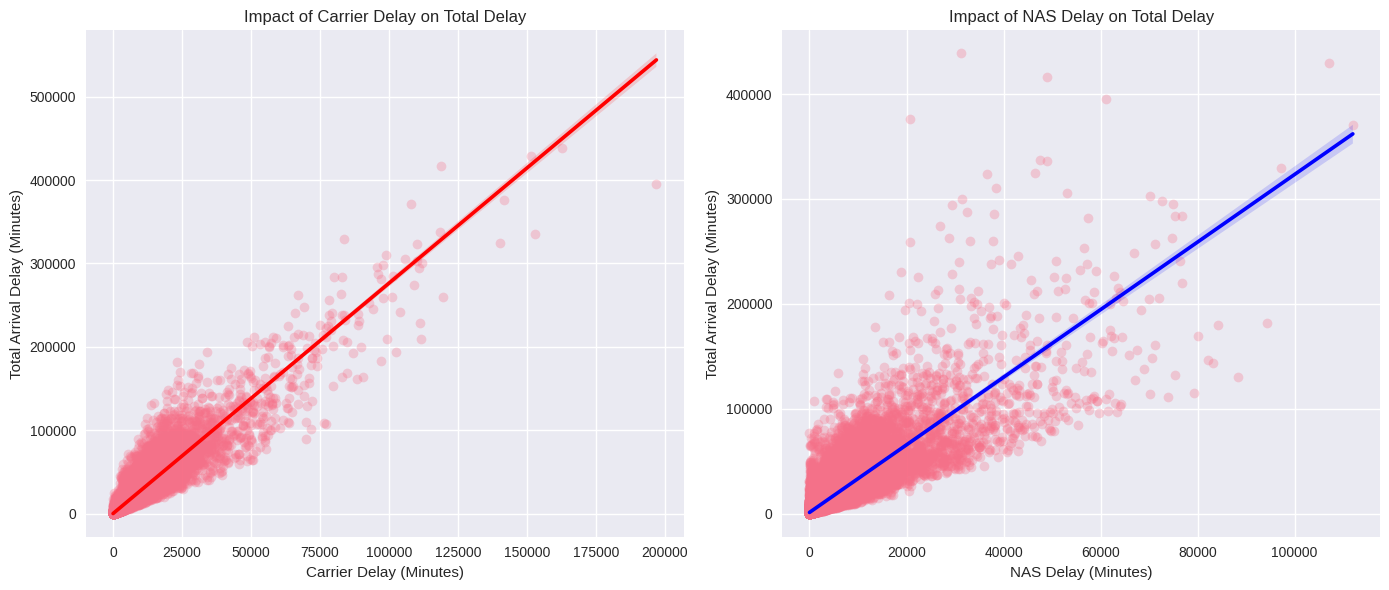

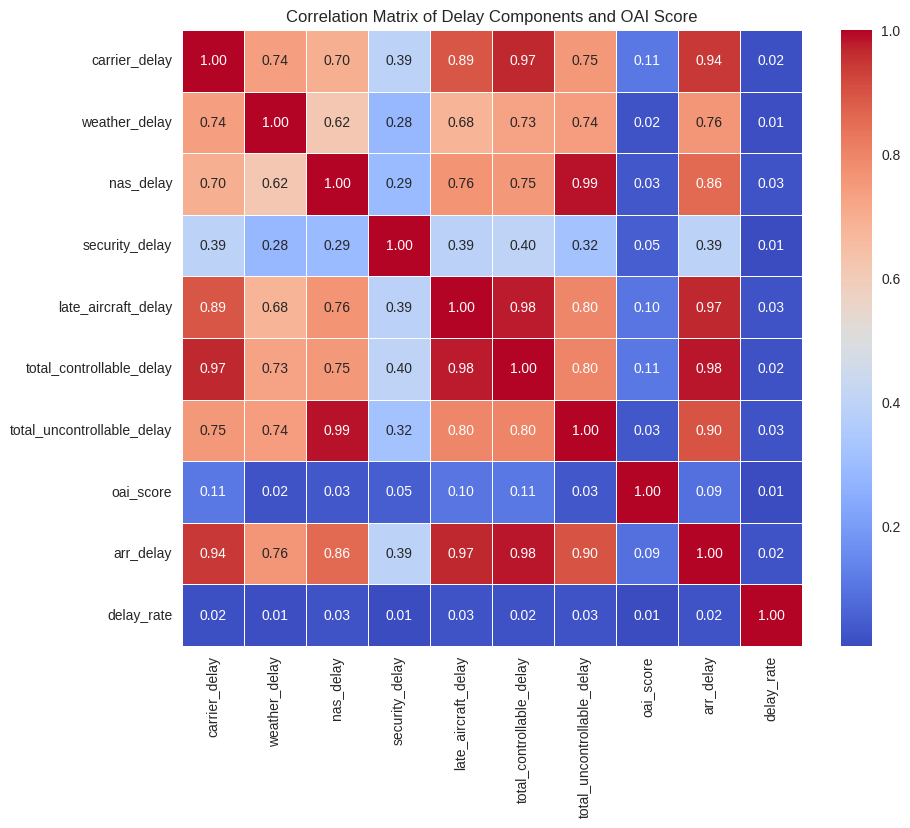

In [669]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.regplot(x='carrier_delay', y='arr_delay', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'red'})
plt.title('Impact of Carrier Delay on Total Delay')
plt.xlabel('Carrier Delay (Minutes)')
plt.ylabel('Total Arrival Delay (Minutes)')

plt.subplot(1, 2, 2)
sns.regplot(x='nas_delay', y='arr_delay', data=df, scatter_kws={'alpha':0.3}, line_kws={'color':'blue'})
plt.title('Impact of NAS Delay on Total Delay')
plt.xlabel('NAS Delay (Minutes)')
plt.ylabel('Total Arrival Delay (Minutes)')
plt.tight_layout()
plt.show()

delay_correlation_cols = [
    'carrier_delay', 'weather_delay', 'nas_delay', 'security_delay', 'late_aircraft_delay',
    'total_controllable_delay', 'total_uncontrollable_delay', 'oai_score', 'arr_delay', 'delay_rate'
]
corr_matrix = df[delay_correlation_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Delay Components and OAI Score')
plt.show()

In [671]:
df = pd.get_dummies(df, columns=['season'], drop_first=True)

In [673]:
# Select features for modeling
feature_cols = ['arr_del15','arr_flights',
               'carrier_ct', 'weather_ct',
               'nas_ct', 'security_ct', 'late_aircraft_ct' ,
                'arr_cancelled', 	'arr_diverted', 	'carrier_delay', 	'weather_delay', 	'nas_delay', 	'security_delay','late_aircraft_delay',
                'total_controllable_delay','total_uncontrollable_delay',
                'season_Winter','season_Spring','season_Summer','oai_score']

# 'delay_per_flight','carrier_delay_rate','late_aircraft_delay_rate','carrier_ct_rate','weather_ct_rate','nas_ct_rate','late_aircraft_ct_rate' ,'delay_rate'
X = df[feature_cols]
y_class = df['is_delayed']  # Classification target
y_reg = df['arr_delay']     # Regression target

In [674]:
df = df.drop(columns=['carrier', 'carrier_name', 'airport', 'airport_name'],inplace=False)

In [675]:
X.head()

,arr_del15,arr_flights,carrier_ct,weather_ct,nas_ct,security_ct,late_aircraft_ct,arr_cancelled,arr_diverted,carrier_delay,weather_delay,nas_delay,security_delay,late_aircraft_delay,total_controllable_delay,total_uncontrollable_delay,season_Winter,season_Spring,season_Summer,oai_score
0,5.0,72.0,2.46,1.00,0.73,0.0,0.81,0.0,0.0,61.0,574.0,20.0,0.0,17.0,78.0,594.0,True,False,False,0.295175
1,7.0,62.0,4.25,0.00,1.00,0.0,1.75,0.0,0.0,252.0,0.0,33.0,0.0,63.0,315.0,33.0,True,False,False,0.971285
2,10.0,95.0,5.94,0.00,1.06,0.0,3.00,0.0,0.0,536.0,0.0,47.0,0.0,276.0,812.0,47.0,True,False,False,0.985512
3,2.0,23.0,0.56,0.00,0.00,0.0,1.44,1.0,0.0,9.0,0.0,0.0,0.0,66.0,75.0,0.0,True,False,False,0.960128
4,256.0,2111.0,76.88,8.75,52.43,0.0,117.94,1.0,0.0,8906.0,732.0,1487.0,0.0,10299.0,19205.0,2219.0,True,False,False,0.974098


In [676]:
# Train-test split
X_train, X_test, y_class_train, y_class_test = train_test_split(
    X, y_class, test_size=0.2, random_state=42
)
X_train_reg, X_test_reg, y_reg_train, y_reg_test = train_test_split(
    X, y_reg, test_size=0.2, random_state=42
)

In [677]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

scaler_reg = StandardScaler()
X_train_reg_scaled = scaler_reg.fit_transform(X_train_reg)
X_test_reg_scaled = scaler_reg.transform(X_test_reg)

In [627]:
print("Training Classification Models with Regularization...")


rf_class = RandomForestClassifier(n_estimators=100, random_state=42)
rf_class.fit(X_train, y_class_train)

# XGBoost Classifier
xgb_class = xgb.XGBClassifier(n_estimators=100, random_state=42)
xgb_class.fit(X_train, y_class_train)

# CatBoost Classifier
cat_class = cb.CatBoostClassifier(random_state=42, verbose=False)
cat_class.fit(X_train, y_class_train)

# Logistic Regression
lr_class = LogisticRegression(random_state=42)
lr_class.fit(X_train_scaled, y_class_train)

Training Classification Models with Regularization...


LogisticRegression(random_state=42)

In [631]:
# Evaluate Classification Models with CV
class_models = [(rf_class, 'Random Forest', X_test),
                (xgb_class, 'XGBoost', X_test),
                (cat_class, 'CatBoost', X_test),
                (lr_class, 'Logistic Regression', X_test_scaled)]

class_results = []
for model, name, X_test_data in class_models:
    y_pred = model.predict(X_test_data)
    y_pred_proba = model.predict_proba(X_test_data)[:, 1] if hasattr(model, 'predict_proba') else None

    results = {
        'Model': name,
        'Accuracy': accuracy_score(y_class_test, y_pred),
        'Precision': precision_score(y_class_test, y_pred),
        'Recall': recall_score(y_class_test, y_pred),
        'F1-Score': f1_score(y_class_test, y_pred),
        'AUC': roc_auc_score(y_class_test, y_pred_proba) if y_pred_proba is not None else None
    }
    class_results.append(results)

class_df = pd.DataFrame(class_results)
print("\nClassification Results:")
print(class_df.round(4))


Classification Results:
                 Model  Accuracy  Precision  Recall  F1-Score     AUC
0        Random Forest    0.9758     0.9706  0.9626    0.9666  0.9978
1              XGBoost    0.9934     0.9901  0.9919    0.9910  0.9999
2             CatBoost    0.9954     0.9930  0.9945    0.9937  0.9999
3  Logistic Regression    0.9756     0.9965  0.9363    0.9655  0.9974


In [632]:
print("Training Regression Models...")

# Random Forest Regressor
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train_reg, y_reg_train)

# XGBoost Regressor
xgb_reg = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgb_reg.fit(X_train_reg, y_reg_train)

# CatBoost Regressor
cat_reg = cb.CatBoostRegressor(random_state=42, verbose=False)
cat_reg.fit(X_train_reg, y_reg_train)

Training Regression Models...


In [633]:
reg_models = [(rf_reg, 'Random Forest', X_test_reg),
              (xgb_reg, 'XGBoost', X_test_reg),
              (cat_reg, 'CatBoost', X_test_reg)]

reg_results = []
for model, name, X_test_data in reg_models:
    y_pred = model.predict(X_test_data)

    # Calculate OAI (Operational Adjustability Index)
    mae = mean_absolute_error(y_reg_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_reg_test, y_pred))
    oai = (0.7 * mae) + (0.3 * rmse)  # Weighted combination prioritizing MAE

    results = {
        'Model': name,
        'MAE': mae,
        'RMSE': rmse,
        'R2': r2_score(y_reg_test, y_pred),
        'OAI': oai
    }
    reg_results.append(results)

reg_df = pd.DataFrame(reg_results)
print("\nRegression Results with OAI:")
print(reg_df.round(4))


Regression Results with OAI:
           Model       MAE       RMSE      R2       OAI
0  Random Forest   22.7664   339.5094  0.9991  117.7893
1        XGBoost  159.1245  1388.1179  0.9848  527.8225
2       CatBoost  141.7450  1198.5733  0.9887  458.7935


In [636]:
best_model_idx = reg_df['OAI'].idxmin()
best_model_name = reg_df.iloc[best_model_idx]['Model']
print(f"\nBest model based on OAI: {best_model_name}")


Best model based on OAI: Random Forest


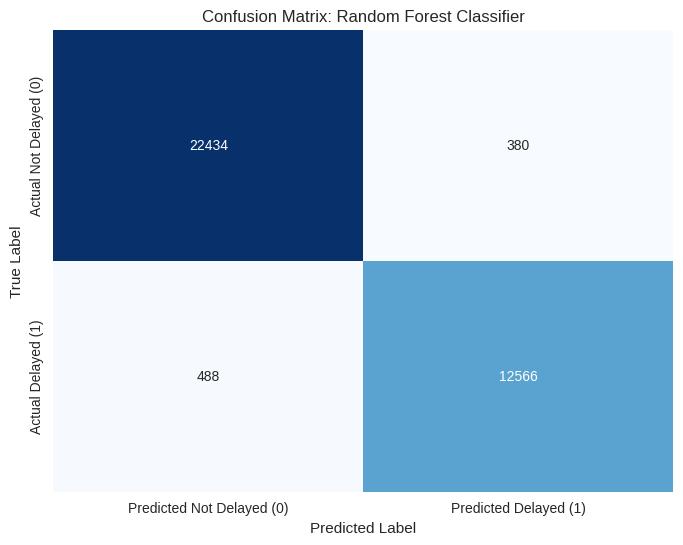

In [643]:
plt.figure(figsize=(8, 6))
y_pred_class = rf_class.predict(X_test)
y_pred_proba_class = rf_class.predict_proba(X_test)[:, 1]

cm = confusion_matrix(y_class_test, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Not Delayed (0)', 'Predicted Delayed (1)'],
            yticklabels=['Actual Not Delayed (0)', 'Actual Delayed (1)'])
plt.title('Confusion Matrix: Random Forest Classifier')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

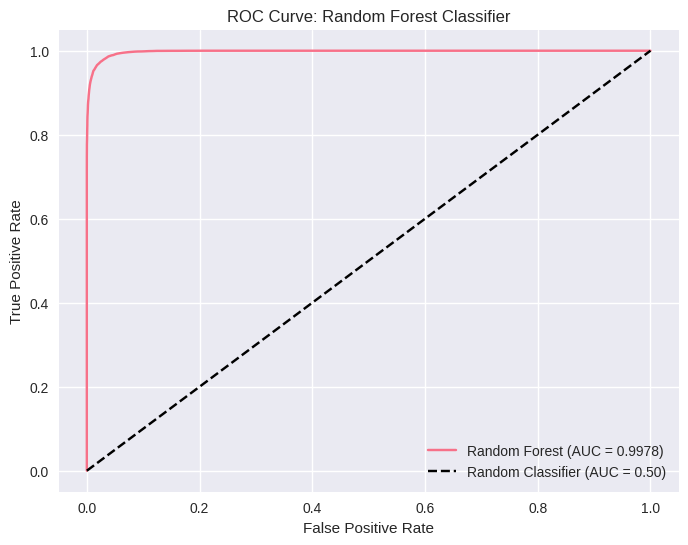

In [646]:
class_accuracy = accuracy_score(y_class_test, y_pred_class)
class_precision = precision_score(y_class_test, y_pred_class)
class_recall = recall_score(y_class_test, y_pred_class)
class_f1 = f1_score(y_class_test, y_pred_class)
class_auc = roc_auc_score(y_class_test, y_pred_proba_class)

plt.figure(figsize=(8, 6))
fpr, tpr, _ = roc_curve(y_class_test, y_pred_proba_class)
plt.plot(fpr, tpr, label=f'Random Forest (AUC = {class_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# SHAP ANALYSIS FOR EXPLAINABILITY

In [501]:
best_model = rf_reg

print(f"Performing SHAP analysis for {best_model_name}...")

# Create SHAP explainer
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for a sample of test data (for efficiency)
sample_size = 100
X_sample = X_test_reg[:sample_size]
shap_values = explainer.shap_values(X_sample)

print(f"SHAP values calculated for {sample_size} samples")

Performing SHAP analysis for Random Forest...
SHAP values calculated for 100 samples


In [502]:
# Define OAI weights for features (higher for controllable factors)
oai_weights = {
    'carrier_ct': 0.9, 'late_aircraft_ct': 0.9, 'carrier_delay': 0.9,
    'late_aircraft_delay': 0.9, 'arr_cancelled': 0.8, 'arr_diverted': 0.8,
    'total_controllable_delay': 0.95,
    'weather_ct': 0.3, 'nas_ct': 0.4, 'security_ct': 0.5,
    'weather_delay': 0.3, 'nas_delay': 0.4, 'security_delay': 0.5,
    'total_uncontrollable_delay': 0.2,
    'arr_del15': 0.6, 'arr_flights': 0.5,
    'season_Winter': 0.4, 'season_Spring': 0.4, 'season_Summer': 0.4
}

# Apply OAI weights to SHAP values
weighted_shap_values = shap_values.copy()
for i, feature in enumerate(feature_cols):
    weight = oai_weights.get(feature, 0.5)  # Default weight for other features
    weighted_shap_values[:, i] *= weight

# VISUALIZATIONS

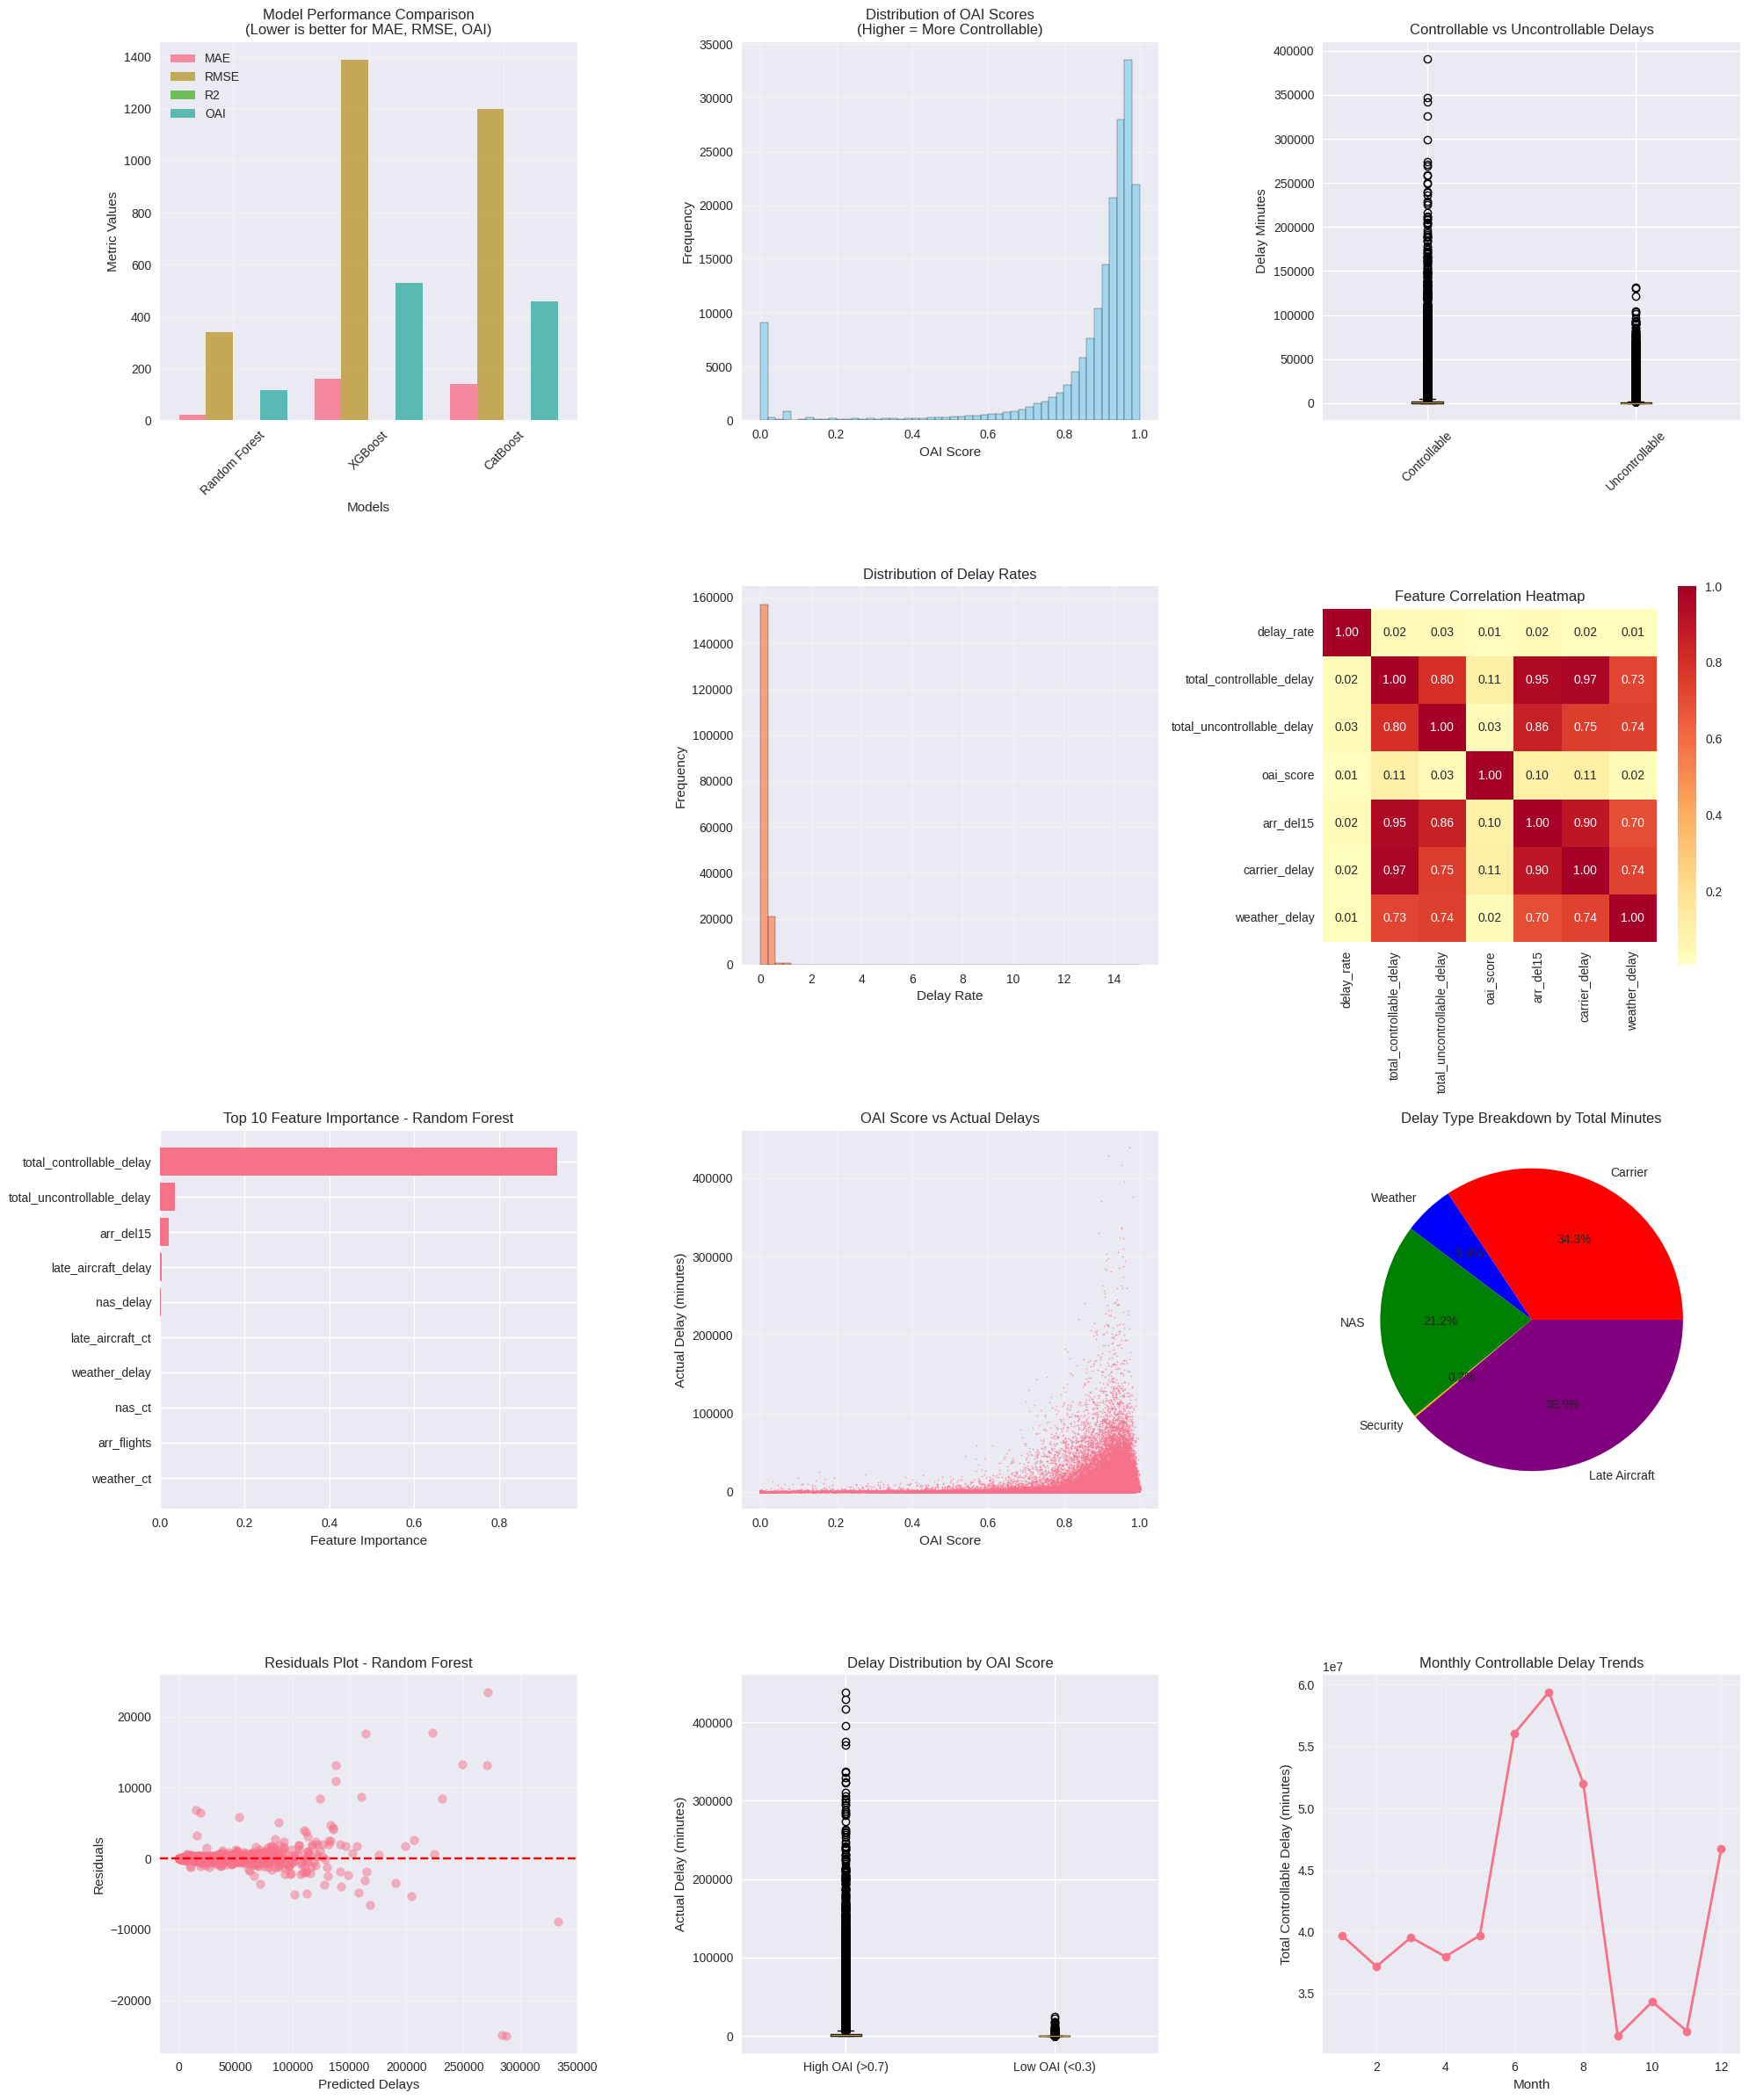

In [507]:
fig = plt.figure(figsize=(20, 24))

# 1. Model Performance Comparison
ax1 = plt.subplot(4, 3, 1)
metrics = ['MAE', 'RMSE', 'R2', 'OAI']
x = np.arange(len(reg_df))
width = 0.2

for i, metric in enumerate(metrics):
    values = reg_df[metric].values
    if metric == 'R2':
        values = np.abs(values)  # Take absolute value for R2 for better visualization
    plt.bar(x + i*width, values, width, label=metric, alpha=0.8)

plt.xlabel('Models')
plt.ylabel('Metric Values')
plt.title('Model Performance Comparison\n(Lower is better for MAE, RMSE, OAI)')
plt.xticks(x + width*1.5, reg_df['Model'], rotation=45)
plt.legend()
plt.grid(True, alpha=0.3)

# 2. OAI Score Distribution
ax2 = plt.subplot(4, 3, 2)
plt.hist(df['oai_score'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('OAI Score')
plt.ylabel('Frequency')
plt.title('Distribution of OAI Scores\n(Higher = More Controllable)')
plt.grid(True, alpha=0.3)

# 3. Controllable vs Uncontrollable Delays
ax3 = plt.subplot(4, 3, 3)
delay_data = [df['total_controllable_delay'], df['total_uncontrollable_delay']]
plt.boxplot(delay_data, labels=['Controllable', 'Uncontrollable'])
plt.title('Controllable vs Uncontrollable Delays')
plt.ylabel('Delay Minutes')
plt.xticks(rotation=45)


# 5. Delay Rate Distribution
ax5 = plt.subplot(4, 3, 5)
plt.hist(df['delay_rate'], bins=50, alpha=0.7, color='coral', edgecolor='black')
plt.xlabel('Delay Rate')
plt.ylabel('Frequency')
plt.title('Distribution of Delay Rates')
plt.grid(True, alpha=0.3)

# 6. Correlation Heatmap for Key Features
ax6 = plt.subplot(4, 3, 6)
key_features = ['delay_rate', 'total_controllable_delay', 'total_uncontrollable_delay',
               'oai_score', 'arr_del15', 'carrier_delay', 'weather_delay']
corr_matrix = df[key_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, ax=ax6,
            square=True, fmt='.2f')
plt.title('Feature Correlation Heatmap')

# 7. Feature Importance from Best Model
ax7 = plt.subplot(4, 3, 7)
if hasattr(best_model, 'feature_importances_'):
    feature_importance = best_model.feature_importances_
    sorted_idx = np.argsort(feature_importance)[-10:]  # Top 10 features
    pos = np.arange(sorted_idx.shape[0])
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, np.array(feature_cols)[sorted_idx])
    plt.xlabel('Feature Importance')
    plt.title(f'Top 10 Feature Importance - {best_model_name}')

# 8. OAI vs Actual Delays Scatter
ax8 = plt.subplot(4, 3, 8)
plt.scatter(df['oai_score'], df['arr_delay'], alpha=0.5, s=1)
plt.xlabel('OAI Score')
plt.ylabel('Actual Delay (minutes)')
plt.title('OAI Score vs Actual Delays')
plt.grid(True, alpha=0.3)

# 9. Delay Type Breakdown
ax9 = plt.subplot(4, 3, 9)
delay_types = ['Carrier', 'Weather', 'NAS', 'Security', 'Late Aircraft']
delay_values = [df['carrier_delay'].sum(), df['weather_delay'].sum(),
               df['nas_delay'].sum(), df['security_delay'].sum(),
               df['late_aircraft_delay'].sum()]
colors = ['red', 'blue', 'green', 'orange', 'purple']
plt.pie(delay_values, labels=delay_types, autopct='%1.1f%%', colors=colors)
plt.title('Delay Type Breakdown by Total Minutes')

# 10. Model Residuals for Best Model
ax10 = plt.subplot(4, 3, 10)
best_model_pred = best_model.predict(X_test_reg)
residuals = y_reg_test - best_model_pred
plt.scatter(best_model_pred, residuals, alpha=0.5)
plt.xlabel('Predicted Delays')
plt.ylabel('Residuals')
plt.title(f'Residuals Plot - {best_model_name}')
plt.axhline(y=0, color='red', linestyle='--')
plt.grid(True, alpha=0.3)

# 11. High vs Low OAI Comparison
ax11 = plt.subplot(4, 3, 11)
high_oai = df[df['oai_score'] > 0.7]['arr_delay']
low_oai = df[df['oai_score'] < 0.3]['arr_delay']
plt.boxplot([high_oai, low_oai], labels=['High OAI (>0.7)', 'Low OAI (<0.3)'])
plt.ylabel('Actual Delay (minutes)')
plt.title('Delay Distribution by OAI Score')

# 12. Controllable Delay Potential Savings
ax12 = plt.subplot(4, 3, 12)
monthly_controllable = df.groupby('month')['total_controllable_delay'].sum()
plt.plot(monthly_controllable.index, monthly_controllable.values, marker='o', linewidth=2)
plt.xlabel('Month')
plt.ylabel('Total Controllable Delay (minutes)')
plt.title('Monthly Controllable Delay Trends')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

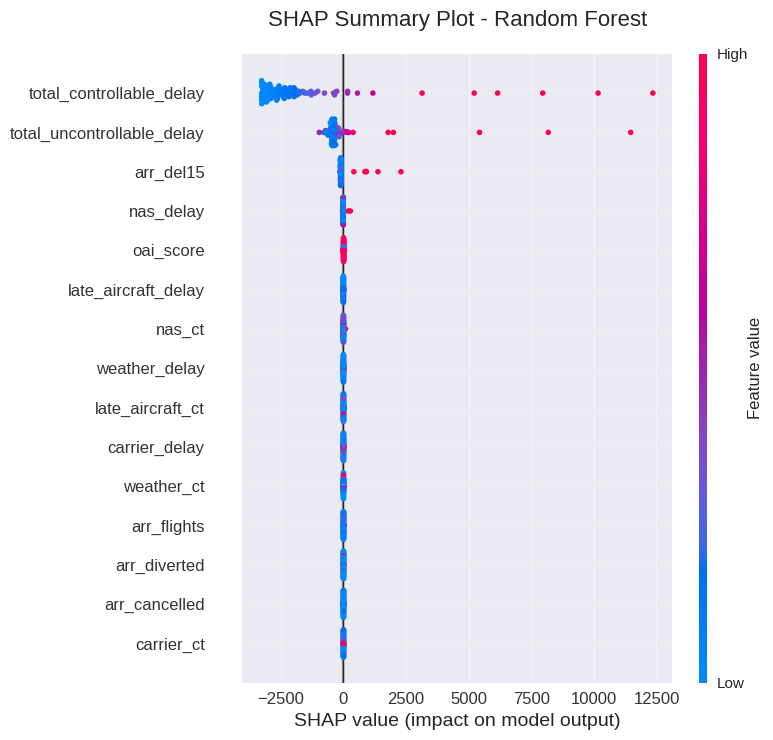

In [508]:
plt.figure(figsize=(12, 10))

# Create the main SHAP summary plot
shap.summary_plot(shap_values, X_sample, feature_names=feature_cols, show=False, max_display=15)
plt.title(f'SHAP Summary Plot - {best_model_name}', fontsize=16, pad=20)
plt.xlabel('SHAP value (impact on model output)', fontsize=14)
plt.ylabel('')
plt.grid(True, alpha=0.3)

# Adjust the plot to match the style in the image
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

# Add a vertical line at x=0
plt.axvline(x=0, color='black', linestyle='-', alpha=0.8, linewidth=1)

# Increase font size for better readability
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tight_layout()
plt.show()

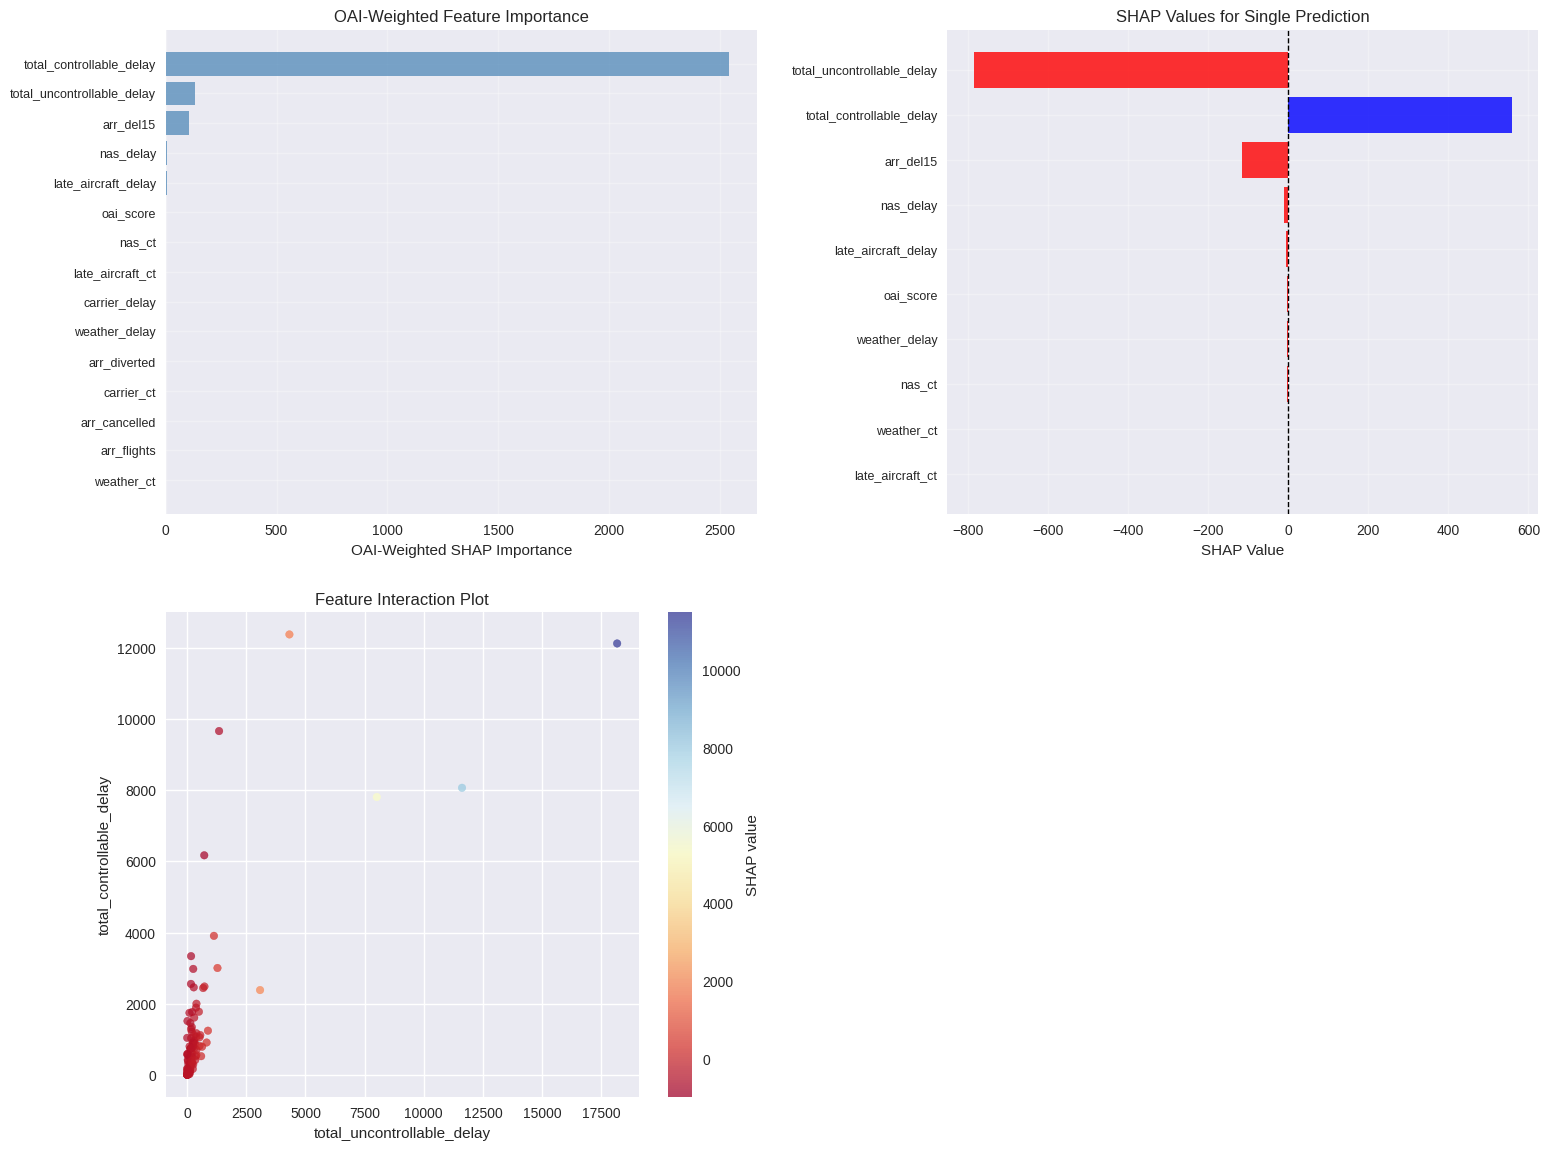

In [535]:
ximport matplotlib.pyplot as plt
import numpy as np
import shap

plt.figure(figsize=(16, 12))

# Subplot 2: OAI-Weighted SHAP Importance
plt.subplot(2, 2, 1)
weighted_importance = np.mean(np.abs(weighted_shap_values), axis=0)
sorted_idx = np.argsort(weighted_importance)[-15:]
plt.barh(range(len(sorted_idx)), weighted_importance[sorted_idx],
         color='steelblue', alpha=0.7)
plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx], fontsize=9)
plt.xlabel('OAI-Weighted SHAP Importance')
plt.title('OAI-Weighted Feature Importance', fontsize=12)
plt.grid(True, alpha=0.3)

# Subplot 3: SHAP Values for a Single Prediction
plt.subplot(2, 2, 2)
if len(shap_values) > 0:
    shap_values_single = shap_values[0]
    sorted_idx = np.argsort(np.abs(shap_values_single))[-10:]
    colors = ['red' if val < 0 else 'blue' for val in shap_values_single[sorted_idx]]
    plt.barh(range(len(sorted_idx)), shap_values_single[sorted_idx], color=colors, alpha=0.8)
    plt.yticks(range(len(sorted_idx)), [feature_cols[i] for i in sorted_idx], fontsize=9)
    plt.xlabel('SHAP Value')
    plt.title('SHAP Values for Single Prediction', fontsize=12)
    plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
    plt.grid(True, alpha=0.3)

# Subplot 4: Feature Interaction Plot
plt.subplot(2, 2, 3)
top_features = np.argsort(np.mean(np.abs(shap_values), axis=0))[-2:]
if len(top_features) == 2:
    f1_idx, f2_idx = top_features
    scatter = plt.scatter(
        X_sample.iloc[:, f1_idx], X_sample.iloc[:, f2_idx],
        c=shap_values[:, f1_idx], cmap='RdYlBu', alpha=0.7, s=30
    )
    plt.xlabel(feature_cols[f1_idx])
    plt.ylabel(feature_cols[f2_idx])
    plt.title('Feature Interaction Plot', fontsize=12)
    cbar = plt.colorbar(scatter)
    cbar.set_label('SHAP value')

plt.tight_layout(pad=2.5)
plt.show()

In [506]:
  # OAI Statistics
print(f"\nOAI Score Statistics:")
print(f"Mean OAI Score: {df['oai_score'].mean():.4f}")
print(f"Median OAI Score: {df['oai_score'].median():.4f}")
print(f"Standard Deviation: {df['oai_score'].std():.4f}")
print(f"High Controllability (OAI > 0.7): {(df['oai_score'] > 0.7).sum():,} flights ({(df['oai_score'] > 0.7).mean()*100:.1f}%)")
print(f"Medium Controllability (0.3 <= OAI <= 0.7): {((df['oai_score'] >= 0.3) & (df['oai_score'] <= 0.7)).sum():,} flights ({((df['oai_score'] >= 0.3) & (df['oai_score'] <= 0.7)).mean()*100:.1f}%)")
print(f"Low Controllability (OAI < 0.3): {(df['oai_score'] < 0.3).sum():,} flights ({(df['oai_score'] < 0.3).mean()*100:.1f}%)")

# Delay Type Analysis
print(f"\nDelay Type Analysis:")
total_controllable = df['total_controllable_delay'].sum()
total_uncontrollable = df['total_uncontrollable_delay'].sum()
total_delay = total_controllable + total_uncontrollable

print(f"Total Controllable Delays: {total_controllable:,.0f} minutes ({total_controllable/total_delay*100:.1f}%)")
print(f"Total Uncontrollable Delays: {total_uncontrollable:,.0f} minutes ({total_uncontrollable/total_delay*100:.1f}%)")
print(f"Average Controllable Delay per Flight: {df['total_controllable_delay'].mean():.2f} minutes")
print(f"Average Uncontrollable Delay per Flight: {df['total_uncontrollable_delay'].mean():.2f} minutes")

# High-Impact Scenarios
high_oai_flights = df[df['oai_score'] > 0.7]
if len(high_oai_flights) > 0:
    print(f"\nHigh-Impact Controllable Delay Scenarios ({len(high_oai_flights):,} flights):")
    print(f"Average delay: {high_oai_flights['arr_delay'].mean():.1f} minutes")
    print(f"Average controllable delay: {high_oai_flights['total_controllable_delay'].mean():.1f} minutes")
    print(f"Potential savings if 50% reduction achieved: {(high_oai_flights['total_controllable_delay'].sum() * 0.5):,.0f} minutes annually")
    print(f"Estimated cost savings (at $100/minute): ${(high_oai_flights['total_controllable_delay'].sum() * 0.5 * 100):,.0f}")



# Feature Importance from SHAP
print(f"\nTop 5 Most Important Features (SHAP Analysis):")
shap_importance = np.mean(np.abs(shap_values), axis=0)
top_features_idx = np.argsort(shap_importance)[-5:][::-1]
for i, idx in enumerate(top_features_idx):
    print(f"{i+1}. {feature_cols[idx]}: {shap_importance[idx]:.4f}")

# OAI-Weighted Feature Importance
print(f"\nTop 5 Most Important Features (OAI-Weighted SHAP):")
weighted_importance = np.mean(np.abs(weighted_shap_values), axis=0)
top_weighted_idx = np.argsort(weighted_importance)[-5:][::-1]
for i, idx in enumerate(top_weighted_idx):
    print(f"{i+1}. {feature_cols[idx]}: {weighted_importance[idx]:.4f}")


OAI Score Statistics:
Mean OAI Score: 0.8499
Median OAI Score: 0.9340
Standard Deviation: 0.2376
High Controllability (OAI > 0.7): 159,627 flights (89.0%)
Medium Controllability (0.3 <= OAI <= 0.7): 8,042 flights (4.5%)
Low Controllability (OAI < 0.3): 11,669 flights (6.5%)

Delay Type Analysis:
Total Controllable Delays: 506,303,297 minutes (73.2%)
Total Uncontrollable Delays: 185,469,843 minutes (26.8%)
Average Controllable Delay per Flight: 2823.18 minutes
Average Uncontrollable Delay per Flight: 1034.19 minutes

High-Impact Controllable Delay Scenarios (159,627 flights):
Average delay: 4264.1 minutes
Average controllable delay: 3155.2 minutes
Potential savings if 50% reduction achieved: 251,824,451 minutes annually
Estimated cost savings (at $100/minute): $25,182,445,100

Top 5 Most Important Features (SHAP Analysis):
1. total_controllable_delay: 2673.6810
2. total_uncontrollable_delay: 671.1313
3. arr_del15: 173.3279
4. nas_delay: 13.9378
5. oai_score: 4.2721

Top 5 Most Importan